# Solving the "mountain car" task using NESTML




In this tutorial, we are going to build an agent that can successfully solve the "mountain car" task using reinforcement learning. [describe the task..]

As a reference point, We will start by using a standard temporal difference (Q-learning) approach and after that, use NESTML to perform the task using a spiking neural network.

## Mountain car environment

For the environment, we mostly need:  
    - A renderer to display the simulation  
    - The physics system
    
We will use the popular "pygame" package to do the rendering. [add citation]

In [1]:
from typing import List, Tuple, Optional

import copy
import enum
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from collections import defaultdict
import sys
import time

import pygame

import nest

nest.set_verbosity("M_ERROR")
nest_local_num_threads = 8   # XXX should be 1 by default

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "k"
mpl.rcParams["grid.linestyle"] = ":"
mpl.rcParams["grid.linewidth"] = 0.5
mpl.rcParams['axes.formatter.useoffset'] = False   # never use offsets on any axis
mpl.rcParams['axes.formatter.use_locale']  = False # optional: also suppress 1 000→1,000 locale formatting

pygame 2.5.0 (SDL 2.28.0, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0-post0.dev0
 Built: Jun  2 2025 16:24:58

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



### Physics of the mountain car task

...


In [2]:
class MountainCarPhysics:
    """
    A custom implementation of the Mountain Car environment.
    Uses Forward Euler integration for physics.
    """

    def __init__(self,
                    dt: float = 10E-3,
                    POS_MIN = -1.5,
                    POS_MAX = 0.6,
                    VEL_MIN = -0.07,
                    VEL_MAX = 0.07,
                    GOAL_POS = 0.5,
                    GRAVITY = 0.0025,
                    FORCE_MAG = 0.0005) -> None:

        self.min_position = POS_MIN
        self.max_position = POS_MAX
        self.min_velocity = VEL_MIN
        self.max_velocity = VEL_MAX
        self.goal_position = GOAL_POS
        self.force_mag = FORCE_MAG
        self.gravity = GRAVITY
        self.dt = dt / 10E-3  # normalize timestep
        
        self.state = self.reset()

    def _height(self, pos):
        """Calculate the height of the mountain at a given position.
        
         Shape is a scaled sine wave.
         """
        return np.sin(3 * pos) * 0.45 + 0.55

    def reset(self):
        r"""
        Resets the environment to a starting state.
        
        Start near the bottom with zero velocity.
        """
        start_pos = random.uniform(-0.6, -0.4)
        start_vel = 0.0
        self.state = (start_pos, start_vel)

        return self.state

    def step(self, action):
        """
        Applies an action, updates the state, and returns new state.
        """
        position, velocity = self.state
        assert action in AgentAction, "Invalid action"

        # --- Physics Update (Forward Euler) ---
        force = 0.
        if action == AgentAction.LEFT:
            force = -self.force_mag
        elif action == AgentAction.RIGHT:
            force = self.force_mag

        velocity += force - self.gravity * np.cos(3 * position)
        velocity = max(self.min_velocity, min(self.max_velocity, velocity)) # Clamp velocity

        position += velocity * self.dt
        position = max(self.min_position, min(self.max_position, position)) # Clamp position

        # --- Check for Goal ---
        done = bool(position >= self.goal_position or position <= self.min_position)

        self.state = (position, velocity)
        
        return self.state, done

    def get_state(self):
        return self.state



To render the environment for visual inspection, we make a class ``Renderer`` that uses pygame:


In [3]:
class MountainCarRenderer:
    
    def __init__(self, env, agent):
        self.env = env
        self.agent = agent
        self.CAR_WIDTH = 20
        self.CAR_HEIGHT = 10
        self.SCREEN_WIDTH = 600
        self.SCREEN_HEIGHT = 400
        
        self.FLAG_X = int((self.env.goal_position - self.env.min_position) / (self.env.max_position - self.env.min_position) * self.SCREEN_WIDTH)
        self.FLAG_Y_BASE = self.SCREEN_HEIGHT // 3
        self.FLAG_HEIGHT = 30
        
    def _init_render(self):
        """Initializes Pygame for rendering."""
        pygame.init()
        self.screen = pygame.display.set_mode((self.SCREEN_WIDTH, self.SCREEN_HEIGHT))
        pygame.display.set_caption("Mountain Car Environment")

        self.clock = pygame.time.Clock()
        try:
            self.font = pygame.font.Font(None, 24) # Default font
        except IOError:
            print("Pygame font not found, using fallback.")
            self.font = pygame.font.SysFont(pygame.font.get_default_font(), 24) # Fallback

    def render(self, episode=None, step=None, total_reward=None, action=None):
        """Renders the current state using Pygame."""
        if self.screen is None:
            self._init_render()

        # Handle quit events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                self.close()
                return False # Indicate rendering should stop

        self.screen.fill((255, 255, 255)) # White background

        # Draw the track
        track_points = []
        for i in range(self.SCREEN_WIDTH):
            pos = env.min_position + (env.max_position - env.min_position) * (i / self.SCREEN_WIDTH)
            height = env._height(pos)
            screen_y = self.SCREEN_HEIGHT - int(height * self.SCREEN_HEIGHT * 0.8) # Scale height
            track_points.append((i, screen_y))
        pygame.draw.lines(self.screen, (0, 0, 0), False, track_points, 2)

        # Draw the goal flag
        flag_world_y = env._height(env.goal_position)
        flag_screen_y = self.SCREEN_HEIGHT - int(flag_world_y * self.SCREEN_HEIGHT * 0.8)
        pygame.draw.line(self.screen, (200, 0, 0), (self.FLAG_X, flag_screen_y), (self.FLAG_X, flag_screen_y - self.FLAG_HEIGHT), 3)
        pygame.draw.polygon(self.screen, (200, 0, 0), [(self.FLAG_X, flag_screen_y - self.FLAG_HEIGHT),
                                                     (self.FLAG_X + 15, flag_screen_y - self.FLAG_HEIGHT + 5),
                                                     (self.FLAG_X, flag_screen_y - self.FLAG_HEIGHT + 10)])

        # Draw the car
        car_pos_norm = (self.env.state[0] - self.env.min_position) / (self.env.max_position - self.env.min_position)
        car_x = int(car_pos_norm * self.SCREEN_WIDTH)
        car_world_y = env._height(self.env.state[0])
        car_y = self.SCREEN_HEIGHT - int(car_world_y * self.SCREEN_HEIGHT * 0.8) # Position car on track

        # Simple rectangle for the car
        car_rect = pygame.Rect(car_x - self.CAR_WIDTH // 2, 
                               car_y - self.CAR_HEIGHT, 
                               self.CAR_WIDTH,
                               self.CAR_HEIGHT)
        pygame.draw.rect(self.screen, (0, 0, 200), car_rect) # Blue car

        # Display stats if available
        if episode is not None and self.font:
            stats_text = f"Episode: {episode} | Step: {step} | Reward: {total_reward:.2f}"
            if not action is None:
                stats_text += " | Action: "
                if action == AgentAction.LEFT:
                    stats_text += "L"
                else:
                    stats_text += "R"
            text_surface = self.font.render(stats_text, True, (0, 0, 0))
            self.screen.blit(text_surface, (10, 10))

        pygame.display.flip()
        self.clock.tick(30) # Limit frame rate
        return True # Indicate rendering succeeded

    def close(self):
        """Closes the Pygame window."""
        if self.screen is not None:
            print("Closing Pygame window.")
            pygame.quit()
            self.screen = None # Mark as closed

# The Agent

In the base class ``Agent``...

The state is a set S of agent observable states. "boxes" (discretizing the state space)...

An action is a set of possible actions A in a state S. Usually, the actions that an agent can do are the same in all states. Therefore, one set of A is represented.

"Over time, it improves its decision-making by updating a Q-table, which stores Q-values representing the expected rewards for taking particular actions in given states."


In [4]:
class AgentAction(enum.Enum):
    LEFT = 0
    RIGHT = 1

class Agent:
    """
    Base class for an agent controlling the mountain car.
    """
    
    def __init__(self, env, NUM_POS_BINS: int = 10, NUM_VEL_BINS: int = 10) -> None:
        self.env = env
        self.pos_bins = self._create_bins(self.env.min_position, self.env.max_position, NUM_POS_BINS)
        self.vel_bins = self._create_bins(self.env.min_velocity, self.env.max_velocity, NUM_VEL_BINS)

        LEARNING_RATE = 0.1  # Alpha
        DISCOUNT_FACTOR = 0.99 # Gamma
        P_EXPLORE_START = 1.   # exploration ratio
        P_EXPLORE_END = 0.  # was: 0.01
        P_EXPLORE_DECAY = .993 # Decay factor per episode
        LEARNING_RATE_DECAY = .998  # learning rate usually decays less fast than exploration probability

        self.MIN_LEARNING_RATE = 0.01

        self.learning_rate = LEARNING_RATE
        self.discount_factor = DISCOUNT_FACTOR
        self.learning_rate_decay = LEARNING_RATE_DECAY
        self.p_explore = P_EXPLORE_START
        self.p_explore_decay = P_EXPLORE_DECAY
        self.p_explore_end = P_EXPLORE_END
        self.POTENTIAL_SCALE_POS = 10.0        
        self.NUM_POS_BINS = NUM_POS_BINS
        self.NUM_VEL_BINS = NUM_VEL_BINS
        
        self.rng = random.Random() # Local random number generator

    def _create_bins(self, min_val, max_val, num_bins):
        r"""Creates discretization bins."""
        if num_bins <= 1:
            return [] # No bins needed if only 1

        bin_size = (max_val - min_val) / num_bins

        # Create thresholds between bins
        return [min_val + i * bin_size for i in range(1, num_bins)]

    def _get_discrete_state(self, state):
        """Converts continuous state (pos, vel) to discrete state (pos_bin, vel_bin)."""
        position, velocity = state

        def _find_bin(value, bins):
            for i, threshold in enumerate(bins):
                if value < threshold:
                    return i
            return len(bins) # Return the last bin index if value >= last threshold

        pos_bin = _find_bin(position, self.pos_bins)
        vel_bin = _find_bin(velocity, self.vel_bins)

        return (pos_bin, vel_bin)
    
    def failure_reset(self, state: Tuple[float,float,float,float]):
        box = self.get_box(state)
        self.current_box = self.boxes[box[0], box[1], box[2], box[3], :]

    def decay_learning_rate(self):
        """Decays the learning rate."""
        self.learning_rate = self.learning_rate * self.learning_rate_decay
        if self.learning_rate < self.MIN_LEARNING_RATE:
            self.learning_rate = 0.

    def decay_p_explore(self):
        """Decays the exploration rate."""
        self.p_explore = max(self.p_explore_end, self.p_explore * self.p_explore_decay)
        if self.p_explore < .01:
            self.p_explore = 0.

    def _potential(self, state):
        """
        Calculates the potential function Phi(s) for reward shaping.
        Higher potential should correlate with being closer to the goal state.
        """
        position, velocity = state
        height = self.env._height(position) # Use the environment's height function
        potential_val = self.POTENTIAL_SCALE_POS * height
        
        return potential_val



Show discretisation:


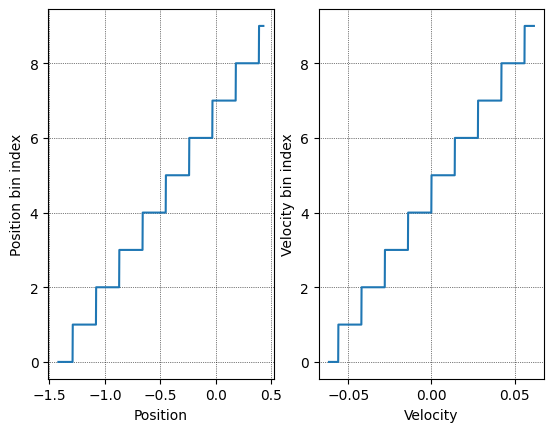

In [5]:
env = MountainCarPhysics()
agent = Agent(env)

pos_min = np.amin(agent.pos_bins)
pos_max = np.amax(agent.pos_bins)
pos_range = np.linspace(pos_min - .1 * np.abs(pos_min),
                        pos_max + .1 * np.abs(pos_max),
                        1000)

pos_idx = np.nan * np.ones_like(pos_range)
for i in range(len(pos_range)):
    pos_idx[i] = agent._get_discrete_state((pos_range[i], 0.))[0]

vel_min = np.amin(agent.vel_bins)
vel_max = np.amax(agent.vel_bins)
vel_range = np.linspace(vel_min - .1 * np.abs(vel_min),
                        vel_max + .1 * np.abs(vel_max),
                        1000)

vel_idx = np.nan * np.ones_like(vel_range)
for i in range(len(vel_range)):
    vel_idx[i] = agent._get_discrete_state((0, vel_range[i]))[1]
    
fig, ax = plt.subplots(ncols = 2)

ax[0].plot(pos_range, pos_idx)
ax[0].set_xlabel(r"Position")
ax[0].set_ylabel(r"Position bin index")

ax[1].plot(vel_range, vel_idx)
ax[1].set_xlabel(r"Velocity")
ax[1].set_ylabel(r"Velocity bin index")

for _ax in ax:
    _ax.grid(True)

## Non-spiking Agent

Agent improves its decision-making by updating a Q-table, which stores Q-values representing the expected rewards for taking particular actions in given states.

In [6]:
class NonSpikingAgent(Agent):
    def __init__(self, env):
        super().__init__(env)

        # Use defaultdict for Q-table for easier handling of unseen states
        # Q[discrete_state_tuple][action] = value
        self.q_table = defaultdict(lambda: [0.0, 0.0]) # 2 actions: left and right move

    def choose_action(self, discrete_state):
        """Chooses an action using p_explore-greedy policy."""
        if self.rng.random() < self.p_explore:
            return self.rng.choice([AgentAction.LEFT, AgentAction.RIGHT]) # Explore: random action

        # Exploit: choose action with highest Q-value.
        # Handle ties randomly.
        q_values = self.q_table[discrete_state]
        max_q = max(q_values)
        best_actions = [action for action, q in zip(AgentAction, q_values) if q == max_q]

        return self.rng.choice(best_actions)

    def update_q_table(self, current_state, action, next_state, done):
        """Updates the Q-table using the Q-learning formula and reward shaping."""
        current_discrete_state = self._get_discrete_state(current_state)
        next_discrete_state = self._get_discrete_state(next_state)

        # --- Calculate Shaping Reward ---
        current_potential = self._potential(current_state)
        next_potential = self._potential(next_state)
        base_reward = -1.
        total_reward = base_reward + self.discount_factor * next_potential - current_potential
    
        # --- Q-Learning Update ---
        old_q_value = self.q_table[current_discrete_state][action.value]

        # Best Q-value for the next state (max_a' Q(s', a'))
        # If terminal state (done), the value of the next state is 0
        next_max_q = max(self.q_table[next_discrete_state]) if not done else 0.0

        if done:
            failure = env.state[0] <= env.min_position
            if failure:
                total_reward = -10.
                
        # Q-update formula
        new_q_value = old_q_value + self.learning_rate * (
            total_reward + self.discount_factor * next_max_q - old_q_value
        )

        self.q_table[current_discrete_state][action.value] = new_q_value
        
        # Return the total (shaped) reward for tracking purposes if needed
        return total_reward



Plot renderer:


In [7]:
class NonSpikingPlotRenderer:
    def __init__(self, env, agent) -> None:
        self.env = env
        self.agent = agent
        self.lifetime_fig, self.lifetime_ax = plt.subplots(nrows=4)
        self.lifetime_ax[0].set_yscale('log')

        self.lifetime_log_line, = self.lifetime_ax[0].plot([], [])
        self.reward_log_line, = self.lifetime_ax[1].plot([], [])
        self.p_explore_log_line, = self.lifetime_ax[2].plot([], [])
        self.learning_rate_log_line, = self.lifetime_ax[3].plot([], [])
        self.lifetime_ax[0].set_ylabel("Steps per episode")
        self.lifetime_ax[1].set_ylabel("Reward per episode")
        self.lifetime_ax[2].set_ylabel("Exploration ratio")
        self.lifetime_ax[3].set_ylabel("Learning rate")
        self.lifetime_ax[-1].set_xlabel("Episode")

    def update(self, episode_idx, lifetime_log, reward_log, p_explore_log, learning_rate_log) -> None:
        if lifetime_log:
            max_lifetime = np.amax(lifetime_log)
            self.lifetime_log_line.set_data(episode_idx, lifetime_log)
            self.lifetime_ax[0].set_xlim(episode_idx[0], episode_idx[-1])
            self.lifetime_ax[0].set_ylim(0, 1.1 * max_lifetime)

        if reward_log:
            self.reward_log_line.set_data(episode_idx, reward_log)
            self.lifetime_ax[1].set_xlim(episode_idx[0], episode_idx[-1])
            self.lifetime_ax[1].set_ylim(np.amin(reward_log), np.amax(reward_log))

        if p_explore_log:
            self.p_explore_log_line.set_data(episode_idx, p_explore_log)
            self.lifetime_ax[2].set_xlim(episode_idx[0], episode_idx[-1])
            self.lifetime_ax[2].set_ylim(np.amin(p_explore_log), np.amax(p_explore_log))

        if learning_rate_log:
            self.learning_rate_log_line.set_data(episode_idx, learning_rate_log)
            self.lifetime_ax[3].set_xlim(episode_idx[0], episode_idx[-1])
            self.lifetime_ax[3].set_ylim(np.amin(learning_rate_log), np.amax(learning_rate_log))

        for _ax in self.lifetime_ax:
            if not _ax == self.lifetime_ax[-1]:
                _ax.set_xticklabels([])

        self.lifetime_fig.canvas.draw()
        self.lifetime_fig.canvas.flush_events()
        self.lifetime_fig.savefig("/tmp/mountain_car_lifetime_nonspiking.png", dpi=300)

        
    def update_q_table_heatmap(self):
        r"""
        Construct heatmap for two parameters
        """
        left_q_table_matrix = np.empty((self.agent.NUM_POS_BINS, self.agent.NUM_VEL_BINS))
        right_q_table_matrix = np.empty((self.agent.NUM_POS_BINS, self.agent.NUM_VEL_BINS))
        for pos_bin in range(self.agent.NUM_POS_BINS):
            for vel_bin in range(self.agent.NUM_VEL_BINS):
                left_q_table_matrix[pos_bin, vel_bin] = self.agent.q_table[(pos_bin, vel_bin)][AgentAction.LEFT.value]
                right_q_table_matrix[pos_bin, vel_bin] = self.agent.q_table[(pos_bin, vel_bin)][AgentAction.RIGHT.value]
    
        # Determine the overall min and max from all datasets.
        global_min = min(left_q_table_matrix.min(), right_q_table_matrix.min())
        global_max = max(left_q_table_matrix.max(), right_q_table_matrix.max())

        # Use symmetric limits so that zero is centered.
        limit = max(abs(global_min), abs(global_max))

        # Create a normalization instance that forces 0 to be the center.
        norm = mpl.colors.TwoSlopeNorm(vmin=-limit, vcenter=0, vmax=limit)
        
        fig, ax = plt.subplots(nrows=3, figsize=(12, 12))

        im1 = ax[0].imshow(left_q_table_matrix, cmap=plt.cm.coolwarm, norm=norm, interpolation='none')
        ax[0].set_title("Q value L")
        im2 = ax[1].imshow(right_q_table_matrix, cmap=plt.cm.coolwarm, norm=norm, interpolation='none')
        ax[1].set_title("Q value R")
        im2 = ax[2].imshow(10*(left_q_table_matrix - right_q_table_matrix), cmap=plt.cm.coolwarm, norm=norm, interpolation='none')
        ax[2].set_title("Q value L - R (x10)")

        for _ax in ax:
            _ax.set_xlabel(r"pos")
            _ax.set_ylabel(r"vel")

        fig.colorbar(im1, ax=ax.ravel().tolist())
        fig.savefig("/tmp/mountain_car_q_table.png", dpi=300)

        plt.close(fig)



Executing Non-Spiking-Agent:


/tmp/ipykernel_135852/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 100/1500, Reward: -508.43, Avg Reward (Last 100): -506.43, p_explore: 0.4954


/tmp/ipykernel_135852/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 200/1500, Reward: -506.08, Avg Reward (Last 100): -494.29, p_explore: 0.2454


/tmp/ipykernel_135852/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 300/1500, Reward: -373.31, Avg Reward (Last 100): -467.66, p_explore: 0.1216


/tmp/ipykernel_135852/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 400/1500, Reward: -411.05, Avg Reward (Last 100): -380.99, p_explore: 0.0602


/tmp/ipykernel_135852/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 500/1500, Reward: -269.34, Avg Reward (Last 100): -337.76, p_explore: 0.0298


/tmp/ipykernel_135852/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 600/1500, Reward: -265.11, Avg Reward (Last 100): -333.28, p_explore: 0.0148


/tmp/ipykernel_135852/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 700/1500, Reward: -255.63, Avg Reward (Last 100): -319.24, p_explore: 0.0000


/tmp/ipykernel_135852/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 800/1500, Reward: -225.64, Avg Reward (Last 100): -306.97, p_explore: 0.0000


/tmp/ipykernel_135852/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 900/1500, Reward: -311.51, Avg Reward (Last 100): -300.41, p_explore: 0.0000


/tmp/ipykernel_135852/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 1000/1500, Reward: -237.05, Avg Reward (Last 100): -302.85, p_explore: 0.0000


/tmp/ipykernel_135852/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 1100/1500, Reward: -269.26, Avg Reward (Last 100): -281.02, p_explore: 0.0000


/tmp/ipykernel_135852/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 1200/1500, Reward: -287.27, Avg Reward (Last 100): -293.43, p_explore: 0.0000


/tmp/ipykernel_135852/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 1300/1500, Reward: -252.75, Avg Reward (Last 100): -312.30, p_explore: 0.0000


/tmp/ipykernel_135852/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 1400/1500, Reward: -300.46, Avg Reward (Last 100): -316.93, p_explore: 0.0000


/tmp/ipykernel_135852/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 1500/1500, Reward: -252.87, Avg Reward (Last 100): -312.45, p_explore: 0.0000


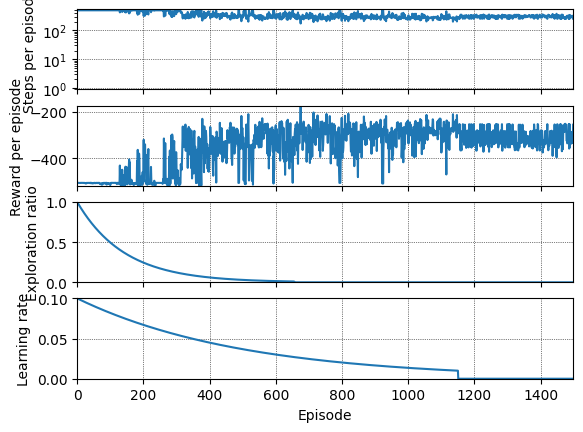

In [8]:
env = MountainCarPhysics()
agent = NonSpikingAgent(env)
r = MountainCarRenderer(env, agent)
r._init_render()
plot = NonSpikingPlotRenderer(env, agent)

episode: int = 0
episode_idx: List[int] = []   # log of number of steps achieved for each episode
steps_per_episode: List[int] = []   # log of number of steps achieved for each episode
learning_rate_log: List[int] = []
p_explore_log: List[int] = []
rewards_per_episode: List[int] = []   # log of total reward achieved in each episode

max_n_episodes: int = 1500
max_steps_per_episode: int = 500   # maximum allowed number of steps per episode

plot_this_episode = True
plot_sim = False
failure = False

render_active = True # Flag to control rendering loop

for episode in range(max_n_episodes):
    done = False

    current_state = env.reset()
    episode_total_reward = 0

    render_this_episode = False
    plot_this_episode = (episode + 1) % 100 == 0

    for step in range(max_steps_per_episode):
        # poll for events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()
            elif event.type == pygame.KEYDOWN:
                plot_sim ^= pygame.key.get_pressed()[pygame.K_SPACE]
 
        discrete_state = agent._get_discrete_state(current_state)
        action = agent.choose_action(discrete_state)
        next_state, done = env.step(action)

        # Update Q-table and get the total (shaped) reward for this step
        step_reward = agent.update_q_table(current_state, action, next_state, done)
        episode_total_reward += step_reward

        current_state = next_state

        # Render if requested and active
        if render_this_episode and render_active:
            r.render(episode, step + 1, episode_total_reward)

        if done:
            break # End episode

    if plot_this_episode:
        plot.update(episode_idx, steps_per_episode, rewards_per_episode, p_explore_log, learning_rate_log)
        plot.update_q_table_heatmap()

    steps_per_episode.append(step)
    episode_idx.append(episode)
    p_explore_log.append(agent.p_explore)
    learning_rate_log.append(agent.learning_rate)
    rewards_per_episode.append(episode_total_reward)

    agent.decay_p_explore()
    agent.decay_learning_rate()

    if (episode + 1) % 100 == 0:
        avg_reward = sum(rewards_per_episode[-100:]) / 100
        print(f"Episode: {episode + 1}/{max_n_episodes}, "
              f"Reward: {episode_total_reward:.2f}, "
              f"Avg Reward (Last 100): {avg_reward:.2f}, "
              f"p_explore: {agent.p_explore:.4f}")




<span style="background-color:yellow">TODO: Make plot of how much q values changed from before training to after training. Are there certain boxes that never get updated? i.e. is the state space (configuration space) adequately explored?</span>


# Spiking version

## Idea

The core principle of our SNN is to simulate the physics and neuron model in sequence, where the state at the end of a physics step is the input for the SNN and the resulting action at the end of a period of SNN simulation is the input to the next physics simulation. Both cycles are set to 40ms to provide the effect that they run simultaneously.
The model's structure consists of two layers of neurons. For each discrete state of the system, the input layer contains a single neuron corresponding to it. Neuromodulated synapses connect these to the output layer, which itself consists of two neuron groups interpreted as actions "move left" and "move right" respectively.

One simulation step of the SNN works as follows:
1. Get the current state of the cart pole and find the designated neuron that only fires when that state is reached.
2. Set a continuous firing rate for the simulation period on that neuron.
3. Determine which of the neuron groups in the output layer has fired more spikes at the end of the step.

# SNN Visualization

In [9]:
def create_weight_matrix(connections):
    """
    Create a weight matrix from NEST connections.
    
    Parameters:
    -----------
    connections : nest.NodeCollection
        Connection object obtained from nest.GetConnections()
        
    Returns:
    --------
    weight_matrix : numpy.ndarray
        Matrix of shape (n_pre, n_post) containing connection weights
    """
    # Get connection properties
    conn_info = connections.get(["source", "target", "weight"])
    
    # Extract source, target, and weight arrays
    sources = np.array(conn_info["source"])
    targets = np.array(conn_info["target"])
    weights = np.array(conn_info["weight"])
    
    # Get unique pre and post neuron IDs
    pre_neurons = np.unique(sources)
    post_neurons = np.unique(targets)
    
    # Create a mapping from neuron IDs to matrix indices
    pre_map = {neuron: i for i, neuron in enumerate(pre_neurons)}
    post_map = {neuron: i for i, neuron in enumerate(post_neurons)}
    
    # Initialize weight matrix with zeros
    n_pre = len(pre_neurons)
    n_post = len(post_neurons)
    weight_matrix = np.zeros((n_pre, n_post))
    
    # Fill the weight matrix
    for src, tgt, w in zip(sources, targets, weights):
        pre_idx = pre_map[src]
        post_idx = post_map[tgt]
        weight_matrix[pre_idx, post_idx] = w
    
    return weight_matrix, pre_neurons, post_neurons


In [10]:
class SpikingPlotRenderer:
    def __init__(self, env, agent) -> None:
        self.env = env
        self.agent = agent

        self.fig, self.ax = plt.subplots(nrows=7, figsize=(12, 10))
        
        # Construct lifetime plot
        self.lifetime_fig, self.lifetime_ax = plt.subplots(nrows=2)
        self.lifetime_line, = self.lifetime_ax[0].plot([0,1], [0,1])
        self.total_reward_per_episode_line, = self.lifetime_ax[1].plot([0,1], [0,1])
        self.lifetime_ax[0].set_ylabel("Steps per episode")
        self.lifetime_ax[1].set_ylabel("Reward per episode")
        self.lifetime_ax[-1].set_xlabel("Episode")

    def update(self, data) -> None:
        if data is None:
            return
        
        self.ax[0].cla()
        self.ax[1].cla()
        self.ax[2].cla()
        self.ax[3].cla()
        self.ax[4].cla()
        self.ax[5].cla()

        # Top plot for spikes
        self.ax[0].set_ylabel("Input Neuron")
        self.ax[0].set_ylim(0, data["n_input_neurons"])
        self.ax[0].plot(data["input_spikes"]["times"], data["input_spikes"]["senders"], ".k", markersize=5)
        
#         self.ax[1].plot(data["multimeter_right_events"]["times"], data["multimeter_right_events"]["V_m"], 'r')
#         self.ax[1].plot(data["multimeter_left_events"]["times"], data["multimeter_left_events"]["V_m"], 'b')

        for neuron_id in np.unique(data["multimeter_left_events"]["senders"]):
            idx = np.where(data["multimeter_left_events"]["senders"] == neuron_id)[0]
            neuron_times = data["multimeter_left_events"]["times"][idx]
            neuron_V_m = data["multimeter_left_events"]["V_m"][idx]
            self.ax[1].plot(neuron_times, neuron_V_m, c="b")

        for neuron_id in np.unique(data["multimeter_right_events"]["senders"]):
            idx = np.where(data["multimeter_right_events"]["senders"] == neuron_id)[0]
            neuron_times = data["multimeter_right_events"]["times"][idx]
            neuron_V_m = data["multimeter_right_events"]["V_m"][idx]
            self.ax[1].plot(neuron_times, neuron_V_m, c="r")
            
        self.ax[1].set_ylabel("V_m [mV]")
        
#         self.ax[2].plot(data["output_spikes_left"]["times"], data["output_spikes_left"]["senders"], ".b", markersize=5)
#         self.ax[2].plot(data["output_spikes_right"]["times"], data["output_spikes_right"]["senders"], ".r", markersize=5)
#         self.ax[2].set_ylabel("Output Neuron")
        self.ax[2].plot(data["model_time_log"], data["n_events_in_last_interval_left_log"], label="left")
        self.ax[2].plot(data["model_time_log"], data["n_events_in_last_interval_right_log"], label="right")
        self.ax[2].legend()
        self.ax[2].set_ylabel("Output Neuron\nfiring rate")
        
        self.ax[3].plot(data["model_time_log"], [action.value for action in data["action_taken"]], "k")
        self.ax[3].set_ylabel("Action taken")
        self.ax[3].set_yticks([AgentAction.LEFT.value, AgentAction.RIGHT.value])
        self.ax[3].set_yticklabels(["LEFT", "RIGHT"])
        
        self.ax[4].plot(data["model_time_log"], data["p_explore_log"], "k")
        self.ax[4].set_ylabel("$p_\mathrm{explore}$")
        self.ax[4].set_ylim(0, 1)
        
        self.ax[5].plot(data["model_time_log"], data["learning_rate_log"], "k")
        self.ax[5].set_ylabel("Learning rate")
        self.ax[5].set_ylim(0, np.amax(data["learning_rate_log"]))
        
        self.ax[6].plot(data["model_time_log"], data["episode_number_detailed_log"], "k")
        self.ax[-1].set_ylabel("Episode")
        
        for _ax in self.ax:
            try:
                _ax.set_xlim(np.min(data["multimeter_right_events"]["times"]), np.max(data["multimeter_right_events"]["times"]))
            except:
                pass
            if not _ax == self.ax[-1]:
                _ax.set_xticklabels([])
        
        self.ax[-1].set_xlabel("Time [ms]")

        # ---------------

        max_lifetime = np.amax(np.array(data["steps_per_episode_log"]) * data["episode_duration"])
        self.lifetime_line.set_data(data["episode_number_log"], np.array(data["steps_per_episode_log"]) * data["episode_duration"])
        self.total_reward_per_episode_line.set_data(data["episode_number_log"], np.array(data["total_reward_per_episode"]))
        for _ax in self.lifetime_ax:
            _ax.set_xlim(data["episode_number_log"][0], data["episode_number_log"][-1])

        if np.amax(data["total_reward_per_episode"]) != np.amin(data["total_reward_per_episode"]):
            self.lifetime_ax[1].set_ylim(np.amin(data["total_reward_per_episode"]), np.amax(data["total_reward_per_episode"]))
        self.lifetime_ax[0].set_ylim(-1E-9, 1.1*max_lifetime)    # the 1E-9 trick is to prevent setting ylim equal to 0, 0 which causes an error
        self.lifetime_ax[0].set_ylabel("Longevity [ms]")
        
        self.ax[-1].set_xlabel("Time [ms]")
        
#         self.fig.canvas.draw()
        self.fig.savefig("/tmp/mountain_car_log.png", dpi=300)
#         self.fig.canvas.flush_events()
        
#         self.lifetime_fig.canvas.draw()
        self.lifetime_fig.savefig("/tmp/mountain_car_spiking_lifetime.png", dpi=300)
#         self.lifetime_fig.canvas.flush_events()

    def update_weights_heatmap(self):
        neuron_pop_base_gid = np.amin(agent.input_population.tolist())    # id of the first neuron in the NodeCollection
        conn_info_left = self.agent.syn_left.get(["source", "target", "weight"])
        conn_info_right = self.agent.syn_right.get(["source", "target", "weight"])

        left_q_table_matrix = np.empty((self.agent.NUM_POS_BINS, self.agent.NUM_VEL_BINS))
        right_q_table_matrix = np.empty((self.agent.NUM_POS_BINS, self.agent.NUM_VEL_BINS))
        for pos_bin in range(self.agent.NUM_POS_BINS):
            for vel_bin in range(self.agent.NUM_VEL_BINS):
                idx = pos_bin + self.agent.NUM_POS_BINS * vel_bin
                input_neuron_gid = neuron_pop_base_gid + idx

                
                # for left

                sources = np.array(conn_info_left["source"])
                targets = np.array(conn_info_left["target"])
                weights = np.array(conn_info_left["weight"])

                assert len(np.unique(targets)) == 1

                idx = np.where(sources == input_neuron_gid)[0]
                
                w = weights[idx]
                
                left_q_table_matrix[pos_bin, vel_bin] = w

                
                # for right

                sources = np.array(conn_info_right["source"])
                targets = np.array(conn_info_right["target"])
                weights = np.array(conn_info_right["weight"])

                assert len(np.unique(targets)) == 1

                idx = np.where(sources == input_neuron_gid)[0]
                
                w = weights[idx]
                
                right_q_table_matrix[pos_bin, vel_bin] = w

                
        # Determine the overall min and max from all datasets.
        global_min = min(left_q_table_matrix.min(), right_q_table_matrix.min())
        global_max = max(left_q_table_matrix.max(), right_q_table_matrix.max())

        # Use symmetric limits so that zero is centered.
        limit = max(abs(global_min), abs(global_max))

        # Create a normalization instance that forces 0 to be the center.
        norm = mpl.colors.TwoSlopeNorm(vmin=-limit, vcenter=0, vmax=limit)
        
        fig, ax = plt.subplots(nrows=3, figsize=(12, 12))

        im1 = ax[0].imshow(left_q_table_matrix, cmap=plt.cm.coolwarm, norm=norm, interpolation='none')
        ax[0].set_title("Q value L")
        im2 = ax[1].imshow(right_q_table_matrix, cmap=plt.cm.coolwarm, norm=norm, interpolation='none')
        ax[1].set_title("Q value R")
        im2 = ax[2].imshow(10*(left_q_table_matrix - right_q_table_matrix), cmap=plt.cm.coolwarm, norm=norm, interpolation='none')
        ax[2].set_title("Q value L - R (x10)")

        for _ax in ax:
            _ax.set_xlabel(r"pos")
            _ax.set_ylabel(r"vel")

        fig.colorbar(im1, ax=ax.ravel().tolist())
        fig.savefig("/tmp/weights_matrix.png", dpi=300)

        plt.close(fig)

        ###
        
        fig, ax = plt.subplots(nrows=1)
        
        ax.plot(np.array(conn_info_left["weight"]), label="left")
        ax.plot(np.array(conn_info_right["weight"]), label="right")
        ax.legend()
        fig.savefig("/tmp/weights_spiking_1D.png", dpi=300)

        plt.close(fig)

        


## NESTML models

Neurons in the input layer will simply be spike generators (ignore_and_fire) that will fire spikes periodically with a given interval.

Neuron model used for the output layer will be iaf_psc_exp.

Input layer neurons are connected through output layer neurons through ``neuromodulated_stdp_synapse``.


In [11]:
# ... generate NESTML model code...

from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils

input_layer_module_name, input_layer_neuron_model_name = \
   NESTCodeGeneratorUtils.generate_code_for("../../../models/neurons/ignore_and_fire_neuron.nestml")

output_layer_module_name, output_layer_neuron_model_name, output_layer_synapse_model_name = \
    NESTCodeGeneratorUtils.generate_code_for("iaf_psc_exp_neuron.nestml",
                                             "neuromodulated_stdp_synapse.nestml",
                                             post_ports=["post_spikes"],
                                             logging_level="DEBUG",
                                             codegen_opts={"delay_variable": {"neuromodulated_stdp_synapse": "d"},
                                                           "weight_variable": {"neuromodulated_stdp_synapse": "w"}})


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0-post0.dev0
 Built: Jun  2 2025 16:24:58

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

[12,ignore_and_fire_neuron_nestml, WARNING, [35:34;35:58]]: Model contains a call to fixed-timestep functions (``resolution()`` and/or ``steps()``). This restricts the model to being compatible only with fixed-timestep simulators. Consider eliminating ``resolution()`` and ``steps()`` from the model, and using ``timestep()`` instead.
[1,GLOBAL, INFO]: List of files that will be processed:
[2,GLOBAL, INFO]: /home/charl/julich/nestml-fork-AlexisWis-cart_pole_tutorial-stash-restore/nestml/doc/tutorials/mountain_car_reinforcement_learning/iaf_psc_exp_neuron.nestml
[3,GLOBAL, INFO]: /home/charl/julich/nestml-fork-AlexisWis-cart_pole_tutorial-stash-restore/n

INFO:Analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "g_e' = (-g_e) / tau_g",
            "initial_values": {
                "g_e": "0.0"
            }
        },
        {
            "expression": "V_m' = (g_e * (E_e - V_m) + E_l - V_m + I_e + I_stim) / tau_m",
            "initial_values": {
                "V_m": "E_l"
            }
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "E_e": "0",
        "E_l": "(-74)",
        "I_e": "0",
        "V_reset": "(-60)",
        "V_th": "(-54)",
        "s": "1000",
        "tau_g": "5",
        "tau_m": "10"
    }
}
INFO:Processing global options...
INFO:Processing input shapes...
INFO:
Processing differential-equation form shape g_e with defining expression = "(-g_e) / tau_g"
DEBUG:Splitting expression -g_e/tau_g (symbols [g_e])
DEBUG:	linear factors: Matrix([[-1/tau_g]])
DEBUG:	inhomogeneous term: 0.0
DEBUG:	nonlinear term: 0.0
DEBUG:Created Shape

[22,GLOBAL, INFO]: State variables that will be moved from synapse to neuron: ['post_trace']
[23,GLOBAL, INFO]: Parameters that will be copied from synapse to neuron: ['tau_tr_post']
[24,GLOBAL, INFO]: Synaptic state variables moved to neuron that will need buffering: []
[25,GLOBAL, INFO]: Moving state var defining equation(s) post_trace
[26,GLOBAL, INFO]: Moving state variables for equation(s) post_trace
[27,GLOBAL, INFO]: Moving definition of post_trace from synapse to neuron
[28,GLOBAL, INFO]: 	Moving statement post_trace += 1 # XXX FIXME!!!! should be ``+= post_trace_increment``
[29,GLOBAL, INFO]: In synapse: replacing ``continuous`` type input ports that are connected to postsynaptic neuron with external variable references
[30,GLOBAL, INFO]: Copying parameters from synapse to neuron...
[31,GLOBAL, INFO]: Copying definition of tau_tr_post from synapse to neuron
[32,GLOBAL, INFO]: Adding suffix to variables in spike updates
[33,GLOBAL, INFO]: In synapse: replacing variables with su

INFO:Saving dependency graph plot to /tmp/ode_dependency_graph_analytically_solvable.dot
DEBUG:os.makedirs('/tmp')
DEBUG:write lines to '/tmp/ode_dependency_graph_analytically_solvable.dot'
DEBUG:run [PosixPath('dot'), '-Kdot', '-Tpdf', '-O', 'ode_dependency_graph_analytically_solvable.dot']
INFO:Generating propagators for the following symbols: g_e
DEBUG:Initializing system of shapes with x = Matrix([[g_e]]), A = Matrix([[-1/tau_g]]), b = Matrix([[0]]), c = Matrix([[0]])
DEBUG:System of equations:
DEBUG:x = Matrix([[g_e]])
DEBUG:A = Matrix([[-1/tau_g]])
DEBUG:b = Matrix([[0]])
DEBUG:c = Matrix([[0]])
INFO:update_expr[g_e] = __P__g_e__g_e*g_e
INFO:Generating numerical solver for the following symbols: V_m
DEBUG:Initializing system of shapes with x = Matrix([[V_m]]), A = Matrix([[-1/tau_m]]), b = Matrix([[E_l/tau_m + I_e/tau_m + I_stim/tau_m]]), c = Matrix([[E_e*g_e/tau_m - V_m*g_e/tau_m]])
INFO:Preserving expression for variable "V_m"
INFO:In ode-toolbox: returning outdict = 
INFO:[
  

INFO:Analysing input:
INFO:{
    "dynamics": [
        {
            "expression": "g_e' = (-g_e) / tau_g",
            "initial_values": {
                "g_e": "0.0"
            }
        },
        {
            "expression": "V_m' = (g_e * (E_e - V_m) + E_l - V_m + I_e + I_stim) / tau_m",
            "initial_values": {
                "V_m": "E_l"
            }
        },
        {
            "expression": "post_trace__for_neuromodulated_stdp_synapse_nestml' = (-post_trace__for_neuromodulated_stdp_synapse_nestml) / tau_tr_post__for_neuromodulated_stdp_synapse_nestml",
            "initial_values": {
                "post_trace__for_neuromodulated_stdp_synapse_nestml": "0.0"
            }
        }
    ],
    "options": {
        "output_timestep_symbol": "__h"
    },
    "parameters": {
        "E_e": "0",
        "E_l": "(-74)",
        "I_e": "0",
        "V_reset": "(-60)",
        "V_th": "(-54)",
        "s": "1000",
        "tau_g": "5",
        "tau_m": "10",
        "tau

DEBUG:	linear factors: Matrix([[E_e/tau_m], [-1/tau_m], [0]])
DEBUG:	inhomogeneous term: E_l/tau_m + I_e/tau_m + I_stim/tau_m
DEBUG:	nonlinear term: -V_m*g_e/tau_m
INFO:Shape post_trace__for_neuromodulated_stdp_synapse_nestml: reconstituting expression -post_trace__for_neuromodulated_stdp_synapse_nestml/tau_tr_post__for_neuromodulated_stdp_synapse_nestml
DEBUG:Splitting expression -post_trace__for_neuromodulated_stdp_synapse_nestml/tau_tr_post__for_neuromodulated_stdp_synapse_nestml (symbols [g_e, V_m, post_trace__for_neuromodulated_stdp_synapse_nestml])
DEBUG:	linear factors: Matrix([[0], [0], [-1/tau_tr_post__for_neuromodulated_stdp_synapse_nestml]])
DEBUG:	inhomogeneous term: 0.0
DEBUG:	nonlinear term: 0.0
INFO:Saving dependency graph plot to /tmp/ode_dependency_graph_analytically_solvable_before_propagated.dot
DEBUG:os.makedirs('/tmp')
DEBUG:write lines to '/tmp/ode_dependency_graph_analytically_solvable_before_propagated.dot'
DEBUG:run [PosixPath('dot'), '-Kdot', '-Tpdf', '-O', 'o

DEBUG:	linear factors: Matrix([[-1/tau_g], [0], [0], [0]])
DEBUG:	inhomogeneous term: 0.0
DEBUG:	nonlinear term: 0.0
DEBUG:Created Shape with symbol g_e, derivative_factors = [-1/tau_g], inhom_term = 0.0, nonlin_term = 0
INFO:	Returning shape: Shape "g_e" of order 1
INFO:
Processing differential-equation form shape V_m with defining expression = "(g_e * (E_e - V_m) + E_l - V_m + I_e + I_stim) / tau_m"
DEBUG:Splitting expression (E_l + I_e + I_stim - V_m + g_e*(E_e - V_m))/tau_m (symbols [g_e, V_m, post_trace__for_neuromodulated_stdp_synapse_nestml, g_e, V_m])
DEBUG:	linear factors: Matrix([[E_e/tau_m], [-1/tau_m], [0], [0], [0]])
DEBUG:	inhomogeneous term: E_l/tau_m + I_e/tau_m + I_stim/tau_m
DEBUG:	nonlinear term: -V_m*g_e/tau_m
DEBUG:Created Shape with symbol V_m, derivative_factors = [-1/tau_m], inhom_term = E_l/tau_m + I_e/tau_m + I_stim/tau_m, nonlin_term = E_e*g_e/tau_m - V_m*g_e/tau_m
INFO:	Returning shape: Shape "V_m" of order 1
INFO:
Processing differential-equation form shape

[38,GLOBAL, INFO]: Analysing/transforming model 'iaf_psc_exp_neuron_nestml__with_neuromodulated_stdp_synapse_nestml'
[39,iaf_psc_exp_neuron_nestml__with_neuromodulated_stdp_synapse_nestml, INFO, [18:0;58:0]]: Starts processing of the model 'iaf_psc_exp_neuron_nestml__with_neuromodulated_stdp_synapse_nestml'


DEBUG:	nonlinear term: 0.0
INFO:Saving dependency graph plot to /tmp/ode_dependency_graph_analytically_solvable_before_propagated.dot
DEBUG:os.makedirs('/tmp')
DEBUG:write lines to '/tmp/ode_dependency_graph_analytically_solvable_before_propagated.dot'
DEBUG:run [PosixPath('dot'), '-Kdot', '-Tpdf', '-O', 'ode_dependency_graph_analytically_solvable_before_propagated.dot']
INFO:Saving dependency graph plot to /tmp/ode_dependency_graph_analytically_solvable.dot
DEBUG:os.makedirs('/tmp')
DEBUG:write lines to '/tmp/ode_dependency_graph_analytically_solvable.dot'
DEBUG:run [PosixPath('dot'), '-Kdot', '-Tpdf', '-O', 'ode_dependency_graph_analytically_solvable.dot']
INFO:Generating numerical solver for the following symbols: g_e, post_trace__for_neuromodulated_stdp_synapse_nestml, V_m
DEBUG:Initializing system of shapes with x = Matrix([[g_e], [V_m], [post_trace__for_neuromodulated_stdp_synapse_nestml]]), A = Matrix([[-1/tau_g, 0, 0], [E_e/tau_m, -1/tau_m, 0], [0, 0, -1/tau_tr_post__for_neurom

[40,GLOBAL, INFO]: Analysing/transforming synapse neuromodulated_stdp_synapse_nestml__with_iaf_psc_exp_neuron_nestml.
[41,neuromodulated_stdp_synapse_nestml__with_iaf_psc_exp_neuron_nestml, INFO, [6:0;55:0]]: Starts processing of the model 'neuromodulated_stdp_synapse_nestml__with_iaf_psc_exp_neuron_nestml'
[42,GLOBAL, INFO]: Rendering template /home/charl/julich/nestml-fork-AlexisWis-cart_pole_tutorial-stash-restore/nestml/doc/tutorials/mountain_car_reinforcement_learning/target/iaf_psc_exp_neuron_nestml.cpp
[43,GLOBAL, INFO]: Rendering template /home/charl/julich/nestml-fork-AlexisWis-cart_pole_tutorial-stash-restore/nestml/doc/tutorials/mountain_car_reinforcement_learning/target/iaf_psc_exp_neuron_nestml.h
[44,iaf_psc_exp_neuron_nestml, INFO, [18:0;58:0]]: Successfully generated code for the model: 'iaf_psc_exp_neuron_nestml' in: '/home/charl/julich/nestml-fork-AlexisWis-cart_pole_tutorial-stash-restore/nestml/doc/tutorials/mountain_car_reinforcement_learning/target' !
[45,GLOBAL, I

/home/charl/julich/nestml-fork-AlexisWis-cart_pole_tutorial-stash-restore/nestml/doc/tutorials/mountain_car_reinforcement_learning/target/neuromodulated_stdp_synapse_nestml__with_iaf_psc_exp_neuron_nestml.h: In instantiation of ‘nest::neuromodulated_stdp_synapse_nestml__with_iaf_psc_exp_neuron_nestml<targetidentifierT>::neuromodulated_stdp_synapse_nestml__with_iaf_psc_exp_neuron_nestml() [with targetidentifierT = nest::TargetIdentifierIndex]’:
/home/charl/julich/nest-simulator-install/include/nest/connector_model.h:164:25:   required from ‘nest::GenericConnectorModel<ConnectionT>::GenericConnectorModel(std::string) [with ConnectionT = nest::neuromodulated_stdp_synapse_nestml__with_iaf_psc_exp_neuron_nestml<nest::TargetIdentifierIndex>; std::string = std::__cxx11::basic_string<char>]’
/home/charl/julich/nest-simulator-install/include/nest/model_manager_impl.h:103:34:   required from ‘void nest::ModelManager::register_specific_connection_model_(const std::string&) [with CompleteConnecion

[100%] Linking CXX shared module nestml_5db106a63cc54757ab6af013c5525511_module.so
[100%] Built target nestml_5db106a63cc54757ab6af013c5525511_module_module
[100%] Built target nestml_5db106a63cc54757ab6af013c5525511_module_module
Install the project...
-- Install configuration: ""
-- Installing: /tmp/nestml_target_bluoj7hw/nestml_5db106a63cc54757ab6af013c5525511_module.so


In [12]:
class SpikingAgent(Agent):
    cycle_period = 25.   # alternate between physics and SNN simulation with this cycle length [ms]
   
    def __init__(self, env) -> None:
        super().__init__(env)
        
        self.constant_reward = -1.
        
        self.Q_left = 0.
        self.Q_right = 0.
        self.Q_left_prev = 0.
        self.Q_right_prev = 0.
        self.Q_old = 0.
        self.Q_new = 0.
        self.scale_n_output_spikes_to_Q_value = 0.1
        self.last_action_chosen = AgentAction.LEFT   # choose first action randomly

        self.POTENTIAL_SCALE_VEL = 10.
        
        self.Wmax = 3.
        self.Wmin = 0.2

        self.n_action_neurons = 1   # number of neurons per action output population (this many for left, and another this many for right, etc.)

        self.INPUT_POPULATION_FIRING_RATE = 500.    # [s⁻¹]
        
        self.construct_neural_network()
        
    def get_state_neuron(self, state) -> int:
        discrete_state = self._get_discrete_state(state)
        idx = discrete_state[0] + self.NUM_POS_BINS * discrete_state[1]
        neuron_pop_base_gid = np.amin(self.input_population.tolist())    # id of the first neuron in the NodeCollection
        
        neuron_gid = neuron_pop_base_gid + idx
        
        if neuron_gid not in self.input_population:
            return None

        return neuron_gid
    
    def construct_neural_network(self):
        nest.ResetKernel()
        nest.local_num_threads = nest_local_num_threads
#         nest.resolution = .01    # [ms]
        nest.resolution = .1    # [ms]
        nest.Install(input_layer_module_name)   # makes the generated NESTML model available
        nest.Install(output_layer_module_name)   # makes the generated NESTML model available

        self.input_size = self.NUM_POS_BINS * self.NUM_VEL_BINS
        self.input_population = nest.Create(input_layer_neuron_model_name, self.input_size)

        self.output_population_left = nest.Create(output_layer_neuron_model_name, self.n_action_neurons)
        self.output_population_right = nest.Create(output_layer_neuron_model_name, self.n_action_neurons)
        
        self.spike_recorder_input = nest.Create("spike_recorder")
        nest.Connect(self.input_population, self.spike_recorder_input)

        self.multimeter_left = nest.Create('multimeter', 1, {'record_from': ['V_m']})
        nest.Connect(self.multimeter_left, self.output_population_left)
        self.multimeter_right = nest.Create('multimeter', 1, {'record_from': ['V_m']})
        nest.Connect(self.multimeter_right, self.output_population_right)

        self.syn_opts = {"synapse_model": output_layer_synapse_model_name,
                        "weight": .5,# + nest.random.uniform(min=0.0, max=1.0) * 0.2, # XXX: "R_STDP" script has ``0.05+rand()*0.001`` instead of ``0.1+rand()*0.02``
                        #"delay": nest.resolution,   # XXX: this slows the simulation down drastically!
                        "tau_tr_pre": 20., # [ms]
                        "tau_tr_post": 20.,  # [ms]
                        "wtr_max": 0.1,
                        "wtr_min": 0.,
                        "pre_trace_increment": 0.0001,
                        "post_trace_increment": -1.05E-7}

        nest.Connect(self.input_population, self.output_population_left, syn_spec=self.syn_opts)
        nest.Connect(self.input_population, self.output_population_right, syn_spec=self.syn_opts)

        syn = nest.GetConnections(source=self.input_population, target=self.output_population_right)
        self.syn_right = nest.GetConnections(source=self.input_population, target=self.output_population_right)
        self.syn_left = nest.GetConnections(source=self.input_population, target=self.output_population_left)

#         print("after network init:")
#         print("\tbefore w = " + str(syn.w))
#         print("\tbefore wtr = " + str(syn.wtr))
    
        self.output_population_spike_recorder_left = nest.Create("spike_recorder")
        nest.Connect(self.output_population_left, self.output_population_spike_recorder_left)

        self.output_population_spike_recorder_right = nest.Create("spike_recorder")
        nest.Connect(self.output_population_right, self.output_population_spike_recorder_right)
        
    def choose_action_based_on_q_values(self) -> AgentAction:
        """Chooses an action using p_explore-greedy policy."""

        # Exploit: choose action with highest Q-value.
        # Handle ties randomly.
        Q_left, Q_right = self.compute_Q_values()
        
        if self.rng.random() < self.p_explore:
            # Explore: random action
            if self.rng.uniform(0, 1) < 0.5:
                self.last_action_chosen = AgentAction.LEFT
                return Q_left, AgentAction.LEFT

            self.last_action_chosen = AgentAction.RIGHT
            return Q_right, AgentAction.RIGHT

        if Q_left > Q_right:
            self.last_action_chosen = AgentAction.LEFT
            return Q_left, AgentAction.LEFT
        
        self.last_action_chosen = AgentAction.RIGHT
        return Q_right, AgentAction.RIGHT
    
    def plot_weight_updates(self, which_side, w, w_old):
        q_table_matrix = np.empty((self.NUM_POS_BINS, self.NUM_VEL_BINS))
        for pos_bin in range(self.NUM_POS_BINS):
            for vel_bin in range(self.NUM_VEL_BINS):
                idx = pos_bin + self.NUM_POS_BINS * vel_bin
                q_table_matrix[pos_bin, vel_bin] = w[idx] - w_old[idx]
                
        # Determine the overall min and max from all datasets.
        global_min = q_table_matrix.min()
        global_max = q_table_matrix.max()

        # Use symmetric limits so that zero is centered.
        limit = max(abs(global_min), abs(global_max))

        # Create a normalization instance that forces 0 to be the center.
        norm = mpl.colors.TwoSlopeNorm(vmin=-limit, vcenter=0, vmax=limit)
        
        fig, ax = plt.subplots(figsize=(12, 12))
        im1 = ax.imshow(q_table_matrix, cmap=plt.cm.coolwarm, norm=norm, interpolation='none')
        ax.set_title("weight update (new - old)")

        ax.set_xlabel(r"pos")
        ax.set_ylabel(r"vel")

        fig.colorbar(im1, ax=ax)
        fig.savefig("/tmp/weights_update_" + which_side + "_" + str(time.time()) + ".png", dpi=300)

        plt.close(fig)

        
        
        # one-dimensional weight update plot
        fig, ax = plt.subplots(ncols=2, figsize=(12,4))

        ax[0].plot(np.arange(len(w)), w_old, label="w_old")
        ax[0].plot(np.arange(len(w)), w, label="w_new")
        ax[0].legend()
        ax[0].set_title("weights (" + which_side + ")")
#         ax[0].set_ylim(0.005, 0.3)

        ax[1].set_title("w_new - w_old")
        ax[1].plot(np.arange(len(w)), w - w_old)
        
        print("Updating " + str(len(np.where(np.abs(w - w_old) > 0)[0])) + " weights")

        fig.savefig("/tmp/w_updates_1D_" + which_side + "_" + str(time.time()) + ".png", dpi=300)
        plt.close(fig)

    def compute_Q_values(self) -> None:
        r"""The output of the SNN is interpreted as the (scaled) Q values."""
        self.n_events_in_last_interval_left = self.output_population_spike_recorder_left.n_events
        self.n_events_in_last_interval_right = self.output_population_spike_recorder_right.n_events
#         print("n_events_in_last_interval_left = " + str(n_events_in_last_interval_left))
#         print("n_events_in_last_interval_right = " + str(n_events_in_last_interval_right))
        self.Q_left = self.scale_n_output_spikes_to_Q_value * self.n_events_in_last_interval_left
        self.Q_right = self.scale_n_output_spikes_to_Q_value * self.n_events_in_last_interval_right

        self.Q_new = np.amax([self.Q_left, self.Q_right])
        
        return self.Q_left, self.Q_right

    def update(self, next_state: Tuple[float, float]) -> Optional[AgentAction]:
        # Reset output population spike recorders
        self.output_population_spike_recorder_left.n_events = 0
        self.output_population_spike_recorder_right.n_events = 0

        # make the correct input neuron fire
        self.input_population.firing_rate = 0.
        neuron_id = self.get_state_neuron(next_state)
        
        # if state was a failure
        if neuron_id is None:
            return None

        self.input_population[neuron_id].firing_rate = self.INPUT_POPULATION_FIRING_RATE

        # simulate for one cycle
        nest.Simulate(SpikingAgent.cycle_period)

    def _potential(self, state, old_state):
        """
        Calculates the potential function Phi(s) for reward shaping.
        Higher potential should correlate with being closer to the goal state.
        
        Options:
        1) potential_val = 10 * self.env._height(position)
    
           # reward increasing the velocity
           if np.abs(velocity) > np.abs(old_velocity):
               potential_val += 1

        2) potential_val = 10 * self.env._height(position)
        
           # when going downhill, punish slowing down
           if self.env._height(position) < self.env._height(old_position) and np.abs(velocity) < np.abs(old_velocity):
               potential_val -= 10.
        """
        position, velocity = state
        old_position, old_velocity = old_state

        potential_val = 10 * self.env._height(position)
    
#         # reward increasing the velocity
#         if np.abs(velocity) > np.abs(old_velocity):
#             potential_val += 1    #0 * (np.abs(velocity) - np.abs(old_velocity))

        # when going downhill, punish slowing down
        if self.env._height(position) < self.env._height(old_position) and np.abs(velocity) < np.abs(old_velocity):
            potential_val -= 10.
            
        return potential_val

    def update_synaptic_weights(self, Q_new, Q_old, action, reward, reset_traces_at_end_of_step=True):
#         print("Updating synaptic weights")

        if Q_old is None:
            return

#         print("reward = " + str(reward))
#         print("Q_new = " + str(Q_new))
#         print("Q_old = " + str(Q_old))
        TD = self.discount_factor * Q_new + 10 * reward - Q_old

        if action == AgentAction.RIGHT:
#             print("\tLast chosen action = RIGHT")
#             print("\tbefore w = " + str(self.syn_right.w))
#             print("\tbefore wtr = " + str(self.syn_right.wtr))

            # w = np.array(self.syn_right.w)
            w = self.syn_right.get("w")
            w_old = w.copy() # XXX only needed for debugging!
            w += self.learning_rate * TD * np.array(self.syn_right.get("wtr"))
            w = np.minimum(w, self.Wmax)
            w = np.maximum(w, self.Wmin)
            self.syn_right.w = w
#             self.plot_weight_updates("right", w, w_old)
        else:
            assert action == AgentAction.LEFT
#             print("Chosen action = LEFT")
#             print("\tbefore w = " + str(self.syn_left.w))
#             print("\tbefore wtr = " + str(self.syn_left.wtr))

            w = self.syn_left.get("w")
            w_old = w.copy() # XXX only needed for debugging!
            w += self.learning_rate * TD * np.array(self.syn_left.get("wtr"))
            w = np.minimum(w, self.Wmax)
            w = np.maximum(w, self.Wmin)
            self.syn_left.w = w
#             self.plot_weight_updates("left", w, w_old)
            

        #
        #    reset synaptic state
        #

        if reset_traces_at_end_of_step:
            for _syn in [self.syn_left, self.syn_right]:
                _syn.wtr = 0.
                _syn.pre_trace = 0.
                #_syn.post_trace = 0. # need to do this in postsyn. neuron partner instead! See the next two lines

            self.output_population_left.post_trace__for_neuromodulated_stdp_synapse_nestml = 0.
            self.output_population_right.post_trace__for_neuromodulated_stdp_synapse_nestml = 0.

# Executing spiking version

The main loop looks like this: for every iteration of the loop (for every "cycle" or "step"):

- simulate neural network: 
    - set the rate of the input neurons to the current state of the environment
    - run the SNN with this input state for a period of time (cycle time, e.g. 10-50 ms)
    - (wtr is computed in each synapse)
- action is selected based on output neuron firing, by counting the number of spikes in the output population over this cycle period
- environment is updated based on action; run the environment for the same cycle time (40 ms) to obtain next state
- reward is computed (neuromodulator signal is proportional to reward)
- synapses that were active (between input and output neurons) have their weights updated (based on wtr * reward)
- wtr of all synapses is reset back to 0

Episode 0 took: 2.396 s
	Number of steps in episode = 499
	Total reward = -14.429986275364584
Episode 1 took: 3.628 s
	Number of steps in episode = 499
	Total reward = -2.3097269263348172
Episode 2 took: 2.961 s
	Number of steps in episode = 499
	Total reward = -5.745195530886559
Episode 3 took: 3.045 s
	Number of steps in episode = 499
	Total reward = -5.162839260667261
Episode 4 took: 3.265 s
	Number of steps in episode = 494
	Total reward = -2.0093830106173436
Episode 5 took: 3.367 s
	Number of steps in episode = 499
	Total reward = -3.484248105324001
Episode 6 took: 3.025 s
	Number of steps in episode = 442
	Total reward = -0.862316426913704
Episode 7 took: 3.484 s
	Number of steps in episode = 492
	Total reward = -2.4798809287375443
Episode 8 took: 3.590 s
	Number of steps in episode = 499
	Total reward = -3.6967923126483626
Episode 9 took: 3.649 s
	Number of steps in episode = 499
	Total reward = -8.838109664200717


/tmp/ipykernel_135852/3878736473.py:131: DeprecationWarning:Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/tmp/ipykernel_135852/3878736473.py:146: DeprecationWarning:Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
DEBUG:locator: <matplotlib.ticker.AutoLocator object at 0x7fe3c8136ed0>


Episode 10 took: 3.902 s
	Number of steps in episode = 499
	Total reward = -8.474306970260933
Episode 11 took: 14.914 s
	Number of steps in episode = 499
	Total reward = -4.171496431406933
Episode 12 took: 4.832 s
	Number of steps in episode = 488
	Total reward = -1.5529026859427615
Episode 13 took: 9.974 s
	Number of steps in episode = 488
	Total reward = -2.1662564152294133
Episode 14 took: 3.491 s
	Number of steps in episode = 457
	Total reward = -2.332099267964661
Episode 15 took: 3.936 s
	Number of steps in episode = 468
	Total reward = -3.974842668742503
Episode 16 took: 4.558 s
	Number of steps in episode = 498
	Total reward = -4.235195462609564
Episode 17 took: 4.816 s
	Number of steps in episode = 499
	Total reward = -4.266898108741331
Episode 18 took: 4.706 s
	Number of steps in episode = 493
	Total reward = -2.2962522883292382
Episode 19 took: 4.718 s
	Number of steps in episode = 488
	Total reward = -1.738135771043018


/tmp/ipykernel_135852/3878736473.py:131: DeprecationWarning:Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/tmp/ipykernel_135852/3878736473.py:146: DeprecationWarning:Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
DEBUG:locator: <matplotlib.ticker.AutoLocator object at 0x7fe3c826ca50>


Episode 20 took: 4.254 s
	Number of steps in episode = 460
	Total reward = -0.5980166104265345
Episode 21 took: 4.664 s
	Number of steps in episode = 492
	Total reward = -3.2709305203253445
Episode 22 took: 4.711 s
	Number of steps in episode = 483
	Total reward = -2.3639374756658995
Episode 23 took: 4.770 s
	Number of steps in episode = 483
	Total reward = -2.2573473423086354
Episode 24 took: 4.600 s
	Number of steps in episode = 457
	Total reward = -1.7980199520269358
Episode 25 took: 4.615 s
	Number of steps in episode = 451
	Total reward = -1.8367791521574466
Episode 26 took: 5.135 s
	Number of steps in episode = 487
	Total reward = -1.0770105658971882
Episode 27 took: 5.256 s
	Number of steps in episode = 495
	Total reward = -2.0753492849253092
Episode 28 took: 4.865 s
	Number of steps in episode = 444
	Total reward = 0.3497993620438027
Episode 29 took: 5.040 s
	Number of steps in episode = 448
	Total reward = -0.8937316034708713


/tmp/ipykernel_135852/3878736473.py:131: DeprecationWarning:Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/tmp/ipykernel_135852/3878736473.py:146: DeprecationWarning:Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
DEBUG:locator: <matplotlib.ticker.AutoLocator object at 0x7fe3c879c650>


Episode 30 took: 5.858 s
	Number of steps in episode = 495
	Total reward = -2.5366703341895085
Episode 31 took: 6.025 s
	Number of steps in episode = 499
	Total reward = -9.732158962214742
Episode 32 took: 6.119 s
	Number of steps in episode = 499
	Total reward = -4.084983674777322
Episode 33 took: 6.191 s
	Number of steps in episode = 499
	Total reward = -10.332046367056178
Episode 34 took: 6.290 s
	Number of steps in episode = 499
	Total reward = -4.625961740618313
Episode 35 took: 5.713 s
	Number of steps in episode = 448
	Total reward = -0.7424877650462732
Episode 36 took: 6.509 s
	Number of steps in episode = 499
	Total reward = -10.412757866309805
Episode 37 took: 6.542 s
	Number of steps in episode = 499
	Total reward = -6.646176399187974
Episode 38 took: 6.379 s
	Number of steps in episode = 480
	Total reward = -2.5253841298115454
Episode 39 took: 6.627 s
	Number of steps in episode = 492
	Total reward = -2.867692170935876


/tmp/ipykernel_135852/3878736473.py:131: DeprecationWarning:Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/tmp/ipykernel_135852/3878736473.py:146: DeprecationWarning:Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
DEBUG:locator: <matplotlib.ticker.AutoLocator object at 0x7fe3f1c568d0>


Episode 40 took: 6.514 s
	Number of steps in episode = 491
	Total reward = -2.506865882547583
Episode 41 took: 6.743 s
	Number of steps in episode = 499
	Total reward = -3.625091740399541
Episode 42 took: 6.853 s
	Number of steps in episode = 499
	Total reward = -10.180668926668451
Episode 43 took: 6.958 s
	Number of steps in episode = 499
	Total reward = -8.193412170871625
Episode 44 took: 6.738 s
	Number of steps in episode = 470
	Total reward = -0.5849281891564296
Episode 45 took: 7.018 s
	Number of steps in episode = 481
	Total reward = -1.518052722351252
Episode 46 took: 7.240 s
	Number of steps in episode = 499
	Total reward = -7.974870087397576
Episode 47 took: 7.327 s
	Number of steps in episode = 499
	Total reward = -5.526891330796331
Episode 48 took: 7.398 s
	Number of steps in episode = 499
	Total reward = -3.609195444307881
Episode 49 took: 7.381 s
	Number of steps in episode = 488
	Total reward = -4.725225310960246


/tmp/ipykernel_135852/3878736473.py:131: DeprecationWarning:Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/tmp/ipykernel_135852/3878736473.py:146: DeprecationWarning:Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
DEBUG:locator: <matplotlib.ticker.AutoLocator object at 0x7fe3b45a0650>


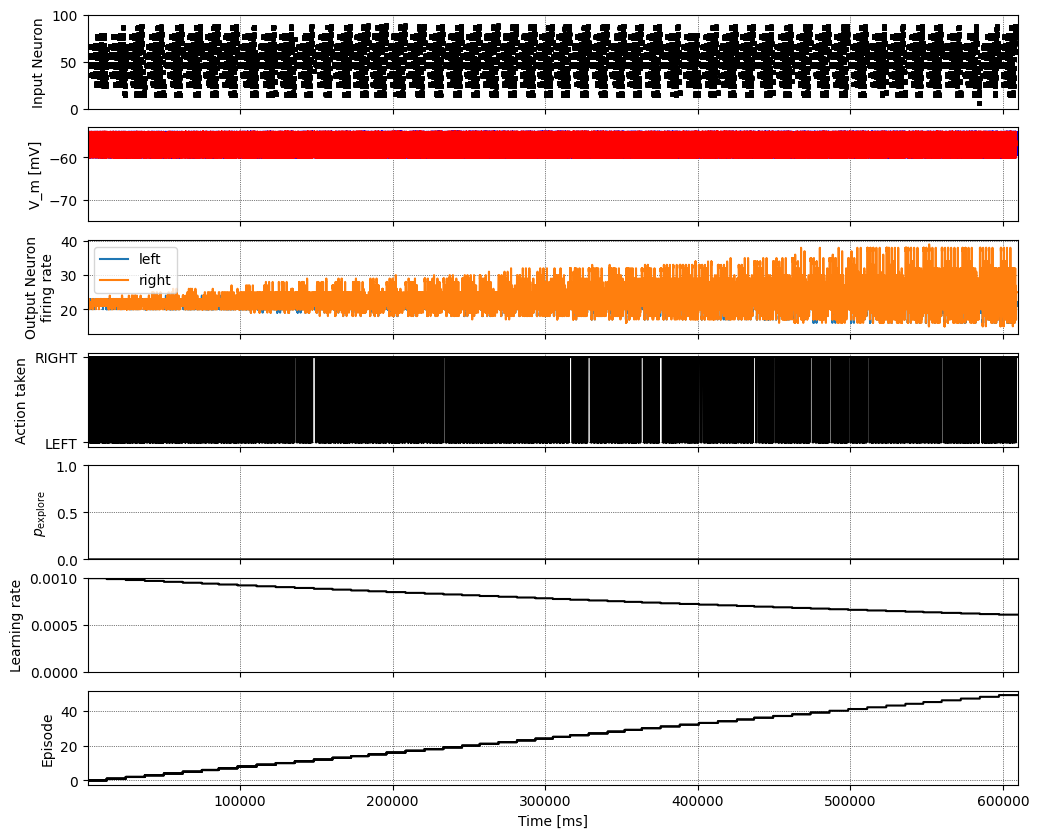

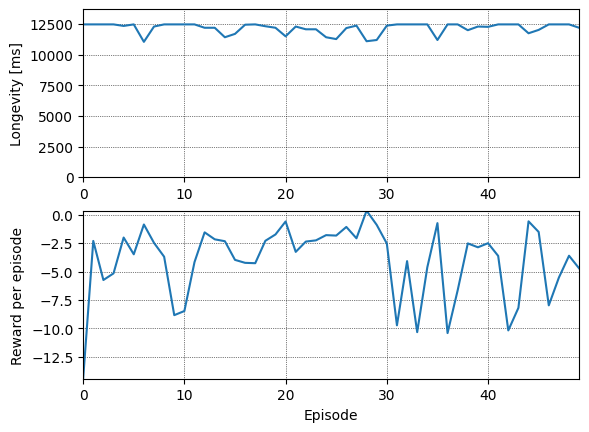

In [13]:
env = MountainCarPhysics()
agent = SpikingAgent(env)

agent.p_explore = 0. # XXX: no exploration! not necessary
agent.learning_rate = 0.001  # was: 0.01
agent.learning_rate_decay = .99
agent.MIN_LEARNING_RATE = agent.learning_rate / 100.

r = MountainCarRenderer(env, agent)
r._init_render()
plot = SpikingPlotRenderer(env, agent)

episode_number_log = []
episode_number_detailed_log = []
steps_per_episode_log = []
episode_number_times = []
episode_number_at_time = []
n_events_in_last_interval_left_log = []
n_events_in_last_interval_right_log = []

model_time_log = []
action_taken = []
p_explore_log = []
rewards_per_episode: List[int] = []   # log of total reward achieved in each episode
learning_rate_log = []

syn_to_left = nest.GetConnections(source=agent.input_population, target=agent.output_population_left)
syn_to_right = nest.GetConnections(source=agent.input_population, target=agent.output_population_right)

max_n_episodes: int = 50
max_steps_per_episode: int = 500   # maximum allowed number of steps per episode

plot_this_episode = True
plot_sim = False
failure = False

# agent chooses action, simulation is updated and reward is calculated

render_active = True # Flag to control rendering loop

Q_old = None
env.reset()
old_state = copy.copy(env.state)

for episode in range(max_n_episodes):
    render_this_episode = False
    plot_this_episode = (episode + 1) % 10 == 0

    env.reset()
    
    episode_total_reward = 0

    start_time_episode = time.time()
    
    for step in range(max_steps_per_episode):

        #
        #    agent chooses action
        #

        agent.update(env.state)
        Q_max, action = agent.choose_action_based_on_q_values()

        if action is None:
            # failure
            break
            
        #
        #    step environment using action
        #
            
        old_old_state = copy.copy(old_state)
        old_state = copy.copy(env.state)
        _, env_done = env.step(action)

        if env_done:
            # success!
            agent.update_synaptic_weights(Q_new=Q_max,
                                          Q_old=Q_old,
                                          action=action,
                                          reward=1.)
            break

        #
        #    change synaptic weights based on environment reward
        #

        step_reward = agent.discount_factor * agent._potential(env.state, old_state) - agent._potential(old_state, old_old_state)   # compute reward in the new state
        step_reward += -.01
        agent.update_synaptic_weights(Q_new=Q_max,
                                      Q_old=Q_old,
                                      action=action,
                                      reward=step_reward)

        Q_old = Q_max
        

        #
        #    Render if requested and active
        #
        
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()
                quit()
            elif event.type == pygame.KEYDOWN:
                render_this_episode ^= pygame.key.get_pressed()[pygame.K_SPACE]
 
        if render_this_episode and render_active:
            r.render(episode, step + 1, step_reward, action)

            
        #
        #    logging
        #

        episode_total_reward += step_reward

        p_explore_log.append(agent.p_explore)
        learning_rate_log.append(agent.learning_rate)
        model_time_log.append(nest.biological_time)
        action_taken.append(action)
        episode_number_detailed_log.append(episode)
        n_events_in_last_interval_left_log.append(agent.n_events_in_last_interval_left)
        n_events_in_last_interval_right_log.append(agent.n_events_in_last_interval_right)
        
    #
    #    print performance stats
    #

    end_time_episode = time.time()
    time_episode = end_time_episode - start_time_episode
    print(f"Episode " + str(episode) + f" took: {time_episode:.3f} s")
    print("\tNumber of steps in episode = " + str(step))
    print("\tTotal reward = " + str(episode_total_reward))

    episode_number_log.append(episode)
    steps_per_episode_log.append(step)
    rewards_per_episode.append(episode_total_reward)
            
    if plot_this_episode:
        plot_data = {
            "input_spikes": nest.GetStatus(agent.spike_recorder_input, keys="events")[0],
            "output_spikes_left": nest.GetStatus(agent.output_population_spike_recorder_left, keys="events")[0],
            "output_spikes_right": nest.GetStatus(agent.output_population_spike_recorder_right, keys="events")[0],
            "multimeter_right_events": agent.multimeter_right.get("events"),
            "multimeter_left_events": agent.multimeter_left.get("events"),
            "n_input_neurons": agent.input_size,
            "total_reward_per_episode": rewards_per_episode
        }

        plot_data["model_time_log"] = model_time_log
        plot_data["action_taken"] = action_taken
        plot_data["p_explore_log"] = p_explore_log
        plot_data["learning_rate_log"] = learning_rate_log
        plot_data["episode_number_log"] = episode_number_log
        plot_data["episode_number_detailed_log"] = episode_number_detailed_log
        plot_data["episode_duration"] = agent.cycle_period
        plot_data["steps_per_episode_log"] = steps_per_episode_log
        plot_data["Wmin"] = agent.Wmin
        plot_data["Wmax"] = agent.Wmax
        plot_data["n_events_in_last_interval_left_log"] = n_events_in_last_interval_left_log
        plot_data["n_events_in_last_interval_right_log"] = n_events_in_last_interval_right_log

        plot.update(plot_data)
        plot.update_weights_heatmap()
        
    agent.decay_p_explore()
    agent.decay_learning_rate()

In [14]:
# run this cell to do benchmarking -- 
#%%prun -s cumulative
#main_simulation_loop()

## Mechanistic explanation: why does this learning principle work?

For high firing rates, STDP basically becomes a purely rate-based rule: weights are predominantely potentiated (rather than depressed) for higher pre- and higher post-synaptic firing rates.

"Gating" the weight updates: only the connections between the input neuron that are active, and the 10 output layer neurons for the action that was chosen, will be updated.

The neuromodulator determines the sign and magnitude of the update, based on TD signal

Simulating pre_rate=5.0 Hz, post_rate=5.0 Hz


/usr/lib/python3/dist-packages/pythran/tables.py:4530: FutureWarning:In the future `np.bool` will be defined as the corresponding NumPy scalar.
/usr/lib/python3/dist-packages/pythran/tables.py:4563: FutureWarning:In the future `np.bytes` will be defined as the corresponding NumPy scalar.
WARNING    'dt' is an internal variable of group 'poissongroup_1', but also exists in the run namespace with the value 100. * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'dt' is an internal variable of group 'poissongroup', but also exists in the run namespace with the value 100. * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'dt' is an internal variable of group 'poissongroup_2', but also exists in the run namespace with the value 100. * usecond. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'dt' is an internal v

Simulating pre_rate=5.0 Hz, post_rate=15.555555555555555 Hz
Simulating pre_rate=5.0 Hz, post_rate=26.11111111111111 Hz
Simulating pre_rate=5.0 Hz, post_rate=36.666666666666664 Hz
Simulating pre_rate=5.0 Hz, post_rate=47.22222222222222 Hz
Simulating pre_rate=5.0 Hz, post_rate=57.77777777777778 Hz
Simulating pre_rate=5.0 Hz, post_rate=68.33333333333333 Hz
Simulating pre_rate=5.0 Hz, post_rate=78.88888888888889 Hz
Simulating pre_rate=5.0 Hz, post_rate=89.44444444444444 Hz
Simulating pre_rate=5.0 Hz, post_rate=100.0 Hz
Simulating pre_rate=15.555555555555555 Hz, post_rate=5.0 Hz
Simulating pre_rate=15.555555555555555 Hz, post_rate=15.555555555555555 Hz
Simulating pre_rate=15.555555555555555 Hz, post_rate=26.11111111111111 Hz
Simulating pre_rate=15.555555555555555 Hz, post_rate=36.666666666666664 Hz
Simulating pre_rate=15.555555555555555 Hz, post_rate=47.22222222222222 Hz
Simulating pre_rate=15.555555555555555 Hz, post_rate=57.77777777777778 Hz
Simulating pre_rate=15.555555555555555 Hz, post

DEBUG:locator: <matplotlib.ticker.AutoLocator object at 0x7fe37d8d65d0>


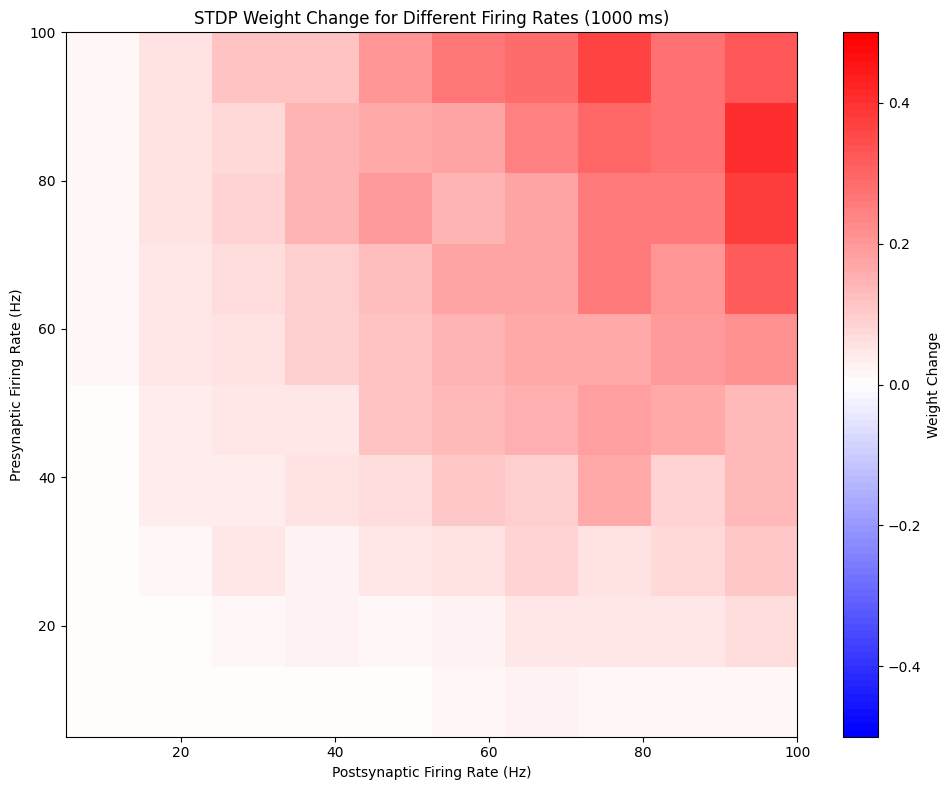

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from brian2 import *

# Simulation parameters
duration = 1000 * ms  # Simulation duration
dt = 0.1 * ms  # Simulation time step

# STDP parameters
tau_pre = 20 * ms
tau_post = 20 * ms
A_pre = 0.001  # LTD amplitude
A_post = 0.001  # LTP amplitude
w_max = 1.0  # Maximum weight

# Range of firing rates to test (Hz)
pre_rates = np.linspace(5, 100, 10)
post_rates = np.linspace(5, 100, 10)

# Initialize result matrix to store final weights
weight_changes = np.zeros((len(pre_rates), len(post_rates)))

# Function to simulate STDP for a given pre and post rate
def simulate_stdp(pre_rate, post_rate):
    # Set up the network
    pre = PoissonGroup(1, rates=pre_rate * Hz)
    post = PoissonGroup(1, rates=post_rate * Hz)
    
    # STDP synapse
    S = Synapses(pre, post,
                '''
                w : 1
                dapre/dt = -apre/tau_pre : 1 (event-driven)
                dapost/dt = -apost/tau_post : 1 (event-driven)
                ''',
                on_pre='''
                apre += A_pre
                w = clip(w + apost, 0, w_max)
                ''',
                on_post='''
                apost += A_post
                w = clip(w + apre, 0, w_max)
                ''')
    
    S.connect()
    S.w = 0.5  # Initial weight
    
    # Record weight changes
    weight_mon = StateMonitor(S, 'w', record=0)
    
    # Run simulation
    run(duration)
    
    # Return the weight change (final - initial)
    return weight_mon.w[0][-1] - 0.5

# Run simulations for all combinations of pre and post rates
for i, pre_rate in enumerate(pre_rates):
    for j, post_rate in enumerate(post_rates):
        print(f"Simulating pre_rate={pre_rate} Hz, post_rate={post_rate} Hz")
        weight_changes[i, j] = simulate_stdp(pre_rate, post_rate)

# Create a custom colormap: blue for depression, white for no change, red for potentiation
colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # Blue -> White -> Red
cmap = LinearSegmentedColormap.from_list('stdp_cmap', colors, N=100)

# Plot the results
plt.figure(figsize=(10, 8))
im = plt.imshow(weight_changes, cmap=cmap, 
                extent=[post_rates[0], post_rates[-1], pre_rates[0], pre_rates[-1]],
                origin='lower', aspect='auto', vmin=-0.5, vmax=0.5)

plt.colorbar(im, label='Weight Change')
plt.xlabel('Postsynaptic Firing Rate (Hz)')
plt.ylabel('Presynaptic Firing Rate (Hz)')
plt.title('STDP Weight Change for Different Firing Rates (1000 ms)')

# Add grid lines
plt.grid(False)
plt.tight_layout()
plt.savefig('stdp_weight_change_heatmap.png', dpi=300)
plt.show()

# Citations

[1] Liu Y, Pan W. Spiking Neural-Networks-Based Data-Driven Control. Electronics. 2023; 12(2):310. https://doi.org/10.3390/electronics12020310 

[2] Kaiser, Jacques & v. Tieck, J. Camilo & Hubschneider, Christian & Wolf, Peter & Weber, Michael & Hoff, Michael & Friedrich, Alexander & Wojtasik, Konrad & Roennau, Arne & Kohlhaas, Ralf & Dillmann, Rüdiger & Zöllner, J.. (2016). Towards a framework for end-to-end control of a simulated vehicle with spiking neural networks. 10.1109/SIMPAR.2016.7862386. 

## Acknowledgements

The authors would like to thank Prof. Wei Pan and Dr. Yuxiang Liu for kindly providing ...